<a href="https://colab.research.google.com/github/RLWH/reinforcement-learning-notebook/blob/master/7.%20Integrating%20Learning%20and%20Planning/Taxi_V2_using_Q_Planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving Taxi-V2 using Integrating Learning and Planning

In [0]:
import gym
import random
import numpy as np

from collections import defaultdict, deque

In [0]:
env = gym.make("Taxi-v2")

In [6]:
obs = env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Model the environment by Tabular Dyna-Q

#### Algorithm - One step Q-planning
---
```
Initialise Q(S,A) and Model(S,A) for all S and A
Do forever:
        1. S = current state
        2. A = epsilon-greedy(S, Q)
        3. Execute A, observe R, S'
        4. Q(S,A) += alpha * [R + gamma * max_a Q(S',A) - Q(S,A)]   <--- [Using One step TD]
        5. Update model
              Model(S,A) <- R, S'
        6. Repeat n times (imagination):
               S <- random previousy observed state
               A <- random action previously taken in S
               R, S' <- Model(S,A)
               Q(S,A) += alpha * [R + gamma * max_a Q(S',A) - Q(S,A)]
```
---

In [0]:
class Model:
    """
    A model represents the environment
    """
    
    def __init__(self, n_states, n_actions):
        self.transitions = np.zeros((n_states, n_actions), dtype="int")
        self.rewards = np.zeros((n_states, n_actions))
        
    def __call__(self, state, action):
        """Retrieve transition and rewards"""
        return self.transitions[state][action], self.rewards[state][action]
        
    def add(self, state, action, reward, next_state):
        """Update the transitions and rewards"""
        self.transitions[state][action] = next_state
        self.rewards[state][action] = reward
        
    def sample(self):
        """Return random state and action"""
        state = np.random.choice(np.where(np.sum(self.transitions, axis=1) > 0)[0])
        action = np.random.choice(np.where(self.transitions[state] > 0)[0])
        return state, action

In [57]:
model = Model(env.observation_space.n, env.action_space.n)
model.add(123, 2, 124, 3)
model.sample()

(123, 2)

In [0]:
def epsilon_greedy_policy(qs, env, eps=0.1):
    """
    Epsilon Greedy Policy
    """
    if random.uniform(0, 1) < eps:
        return env.action_space.sample()
    else:
        return np.argmax(qs)

In [0]:
def one_step_planning(env, num_episodes=10000, n_imagination=5, 
                      initial_eps=0.3, min_eps=0.01, eps_decay_rate=1e-5, 
                      initial_alpha=0.3, min_alpha=0.1, alpha_decay_rate=1e-5,
                      gamma=0.90):
    """Assume the environment is deterministic"""
    
    Q_table = np.zeros([env.observation_space.n, env.action_space.n])
    model = Model(env.observation_space.n, env.action_space.n)
    
    cum_return = []
    
    eps = initial_eps
    alpha = initial_alpha
    
    for i in range(num_episodes + 1):
        # Initialise the environment
        R = 0
        state = env.reset()
        
        
        eps = min(min_eps, eps * (1-eps_decay_rate))
        alpha = min(min_alpha, alpha * (1-alpha_decay_rate))
        
        # Print status
        print("\rTraining episode %s/%s \t" % (i, num_episodes), end="")

        while True:

            action = epsilon_greedy_policy(Q_table[state], env, eps=eps)
            next_state, reward, done, _ = env.step(action)
            
            R += reward
            
            Q_table[state][action] += (alpha
                                       * (reward
                                          + gamma * np.max(Q_table[next_state])
                                          - Q_table[state][action]))

            # Update model
            model.add(state, action, reward, next_state) 

            # Imagination part
            for j in range(n_imagination):
                j_state, j_action = model.sample()
                j_next_state, j_reward = model(j_state, j_action)
                Q_table[j_state][j_action] += (alpha
                                               * (j_reward
                                                  + gamma * np.max(Q_table[j_next_state])
                                                  - Q_table[j_state][j_action]))
            
            if done:
                cum_return.append(R)
                break

            state = next_state
        
        if i % 500 == 0:
            print("Mean reward of last 100 episodes: %s" % np.mean(cum_return[-100:]))
        
    
    return Q_table, model, cum_return

In [139]:
dynaq_5_q, dynaq_5_m, dynaq_5_r = one_step_planning(env, n_imagination=5)
dynaq_10_q, dynaq_10_m, dynaq_10_r = one_step_planning(env, n_imagination=10)
dynaq_50_q, dynaq_50_m, dynaq_50_r = one_step_planning(env, n_imagination=50)
# dynaq_100_q, dynaq_100_m, dynaq_100_r = one_step_planning(env, n_imagination=100)
# dynaq_150_q, dynaq_150_m, dynaq_150_r = one_step_planning(env, n_imagination=150)
q_learning_q, _, q_learning_r = one_step_planning(env, n_imagination=0)

Training episode 0/10000 	Mean reward of last 100 episodes: -470.0
Training episode 500/10000 	Mean reward of last 100 episodes: 5.1
Training episode 1000/10000 	Mean reward of last 100 episodes: 7.91
Training episode 1500/10000 	Mean reward of last 100 episodes: 8.11
Training episode 2000/10000 	Mean reward of last 100 episodes: 7.98
Training episode 2500/10000 	Mean reward of last 100 episodes: 7.96
Training episode 3000/10000 	Mean reward of last 100 episodes: 7.84
Training episode 3500/10000 	Mean reward of last 100 episodes: 7.95
Training episode 4000/10000 	Mean reward of last 100 episodes: 7.84
Training episode 4500/10000 	Mean reward of last 100 episodes: 7.6
Training episode 5000/10000 	Mean reward of last 100 episodes: 8.04
Training episode 5500/10000 	Mean reward of last 100 episodes: 7.84
Training episode 6000/10000 	Mean reward of last 100 episodes: 8.15
Training episode 6500/10000 	Mean reward of last 100 episodes: 8.26
Training episode 7000/10000 	Mean reward of last 100

#### Plot the cumulative returns

In [0]:
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

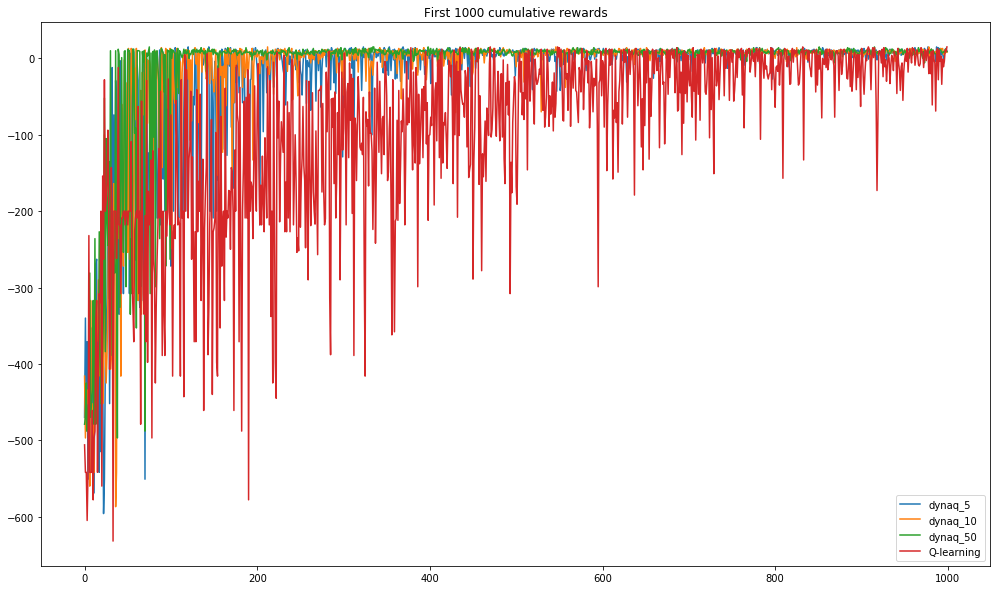

In [145]:
fig, ax = plt.subplots(figsize=(17,10))
ax.plot(dynaq_5_r[:1000], label="dynaq_5")
ax.plot(dynaq_10_r[:1000], label="dynaq_10")
ax.plot(dynaq_50_r[:1000], label="dynaq_50")
# ax.plot(dynaq_150_r, label="dynaq_150")
ax.plot(q_learning_r[:1000], label="Q-learning")
ax.legend()
ax.set_title("First 1000 cumulative rewards")
plt.show()